# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from ml.regression import linear_least_squares
from ml.features import polynomial_features
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from ml.visualization import plot_confusion_matrix, plot_learning_curve

from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import GridSearchCV, train_test_split

# TODO: Agregar las librerías que hagan falta

np.random.seed(0)  # Para mayor determinismo

## Carga de datos

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

# Context
#=======
The consumer credit department of a bank wants to automate the decisionmaking
#process for approval of home equity lines of credit. To do this, they will
#follow the recommendations of the Equal Credit Opportunity Act to create an
#empirically derived and statistically sound credit scoring model. The model
#will be based on data collected from recent applicants granted credit through
#the current process of loan underwriting. The model will be built from
#predictive modeling tools, but the created model must be sufficiently
#interpretable to provide a reason for any adverse actions (rejections).

# Content
#=======
#The Home Equity dataset (HMEQ) contains baseline and loan performance
#information for 5,960 recent home equity loans. The target (BAD) is a binary
#variable indicating whether an applicant eventually defaulted or was
#seriously delinquent. This adverse outcome occurred in 1,189 cases (20%). For
#each applicant, 12 input variables were recorded. 

# Attributes
#==========
#Name    Description
#TARGET  Label: 1 = client defaulted on loan - 0 = loan repaid
#LOAN    Amount of the loan request
#MORTDUE Amount due on existing mortgage
#VALUE   Value of current property
#YOJ     Years at present job
#DEROG   Number of major derogatory reports
#DELINQ  Number of delinquent credit lines
#CLAGE   Age of oldest trade line in months
#NINQ    Number of recent credit lines
#CLNO    Number of credit lines
#DEBTINC Debt-to-income ratio

In [3]:
dataset = pd.read_csv("./data/loan_data.csv", comment="#")
display(dataset.head())

# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

##dataset.iloc[0:5, 1:] # [:,:] seleccion de filas , seleccion de columnas


,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106


In [4]:
dataset.describe()

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000
mean,0.166667,19111.758360,76316.051780,107321.088457,8.900216,0.187702,0.319849,180.300783,1.128910,21.857066,34.573408
std,0.372779,11000.345961,46227.026585,56039.685066,7.552677,0.704882,0.928452,84.838308,1.664555,9.510840,9.308794
min,0.000000,1700.000000,5627.000000,21144.000000,0.000000,0.000000,0.000000,0.486711,0.000000,0.000000,0.838118
25%,0.000000,12000.000000,48984.750000,70787.250000,3.000000,0.000000,0.000000,116.970718,0.000000,16.000000,29.427210
50%,0.000000,17000.000000,67201.000000,94198.000000,7.000000,0.000000,0.000000,174.967815,1.000000,21.000000,35.363407
75%,0.000000,23900.000000,93731.500000,122976.250000,13.000000,0.000000,0.000000,232.261800,2.000000,27.000000,39.357987
max,1.000000,89800.000000,399412.000000,512650.000000,41.000000,10.000000,10.000000,1168.233561,13.000000,65.000000,144.189001


In [5]:
dataset.corr()

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
TARGET,1.000000,-0.042249,-0.023325,-0.035457,-0.079003,0.281370,0.318346,-0.158654,0.138429,0.025141,0.266687
LOAN,-0.042249,1.000000,0.287783,0.405931,0.121605,-0.037464,-0.052864,0.069816,0.014474,0.077883,0.148538
MORTDUE,-0.023325,0.287783,1.000000,0.870438,-0.088004,-0.046021,-0.037257,0.137734,0.038041,0.313263,0.196496
VALUE,-0.035457,0.405931,0.870438,1.000000,0.000460,-0.040697,-0.051153,0.211303,-0.004536,0.209675,0.144466
YOJ,-0.079003,0.121605,-0.088004,0.000460,1.000000,-0.065208,0.031413,0.205617,-0.062207,-0.004256,-0.070128
DEROG,0.281370,-0.037464,-0.046021,-0.040697,-0.065208,1.000000,0.158896,-0.084131,0.201062,0.087320,0.053629
DELINQ,0.318346,-0.052864,-0.037257,-0.051153,0.031413,0.158896,1.000000,0.012180,0.027082,0.131321,0.065445
CLAGE,-0.158654,0.069816,0.137734,0.211303,0.205617,-0.084131,0.012180,1.000000,-0.134256,0.185443,-0.077005
NINQ,0.138429,0.014474,0.038041,-0.004536,-0.062207,0.201062,0.027082,-0.134256,1.000000,0.083897,0.124341
CLNO,0.025141,0.077883,0.313263,0.209675,-0.004256,0.087320,0.131321,0.185443,0.083897,1.000000,0.146505


In [6]:
dataset.isnull().sum()

TARGET     0
LOAN       0
MORTDUE    0
VALUE      0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

## Ejercicio 1: División de datos en conjuntos de entrenamiento y evaluación

La primer tarea consiste en dividir el conjunto de datos cargados en el apartado anterior en conjuntos de entrenamiento (o *training*) y evaluación (o *test*).

El primero será utilizado para la creación/selección del modelo de clasificación. El segundo se utilizará sólo al final (una vez elegidos los mejores hiperparámetros) para ver cuál es el resultado final del modelo sobre un conjunto de datos independiente.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #separamos los datos entre 80, 20

# TODO: Dividir en datos de entrenamiento y evaluación

In [28]:
print(dataset["TARGET"].value_counts())

0    1545
1     309
Name: TARGET, dtype: int64


In [64]:
print(y_train.value_counts())
print(y_test.value_counts())

0    1242
1     241
Name: TARGET, dtype: int64
0    303
1     68
Name: TARGET, dtype: int64


In [66]:
y_train.describe()

count    1483.000000
mean        0.162508
std         0.369041
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: TARGET, dtype: float64

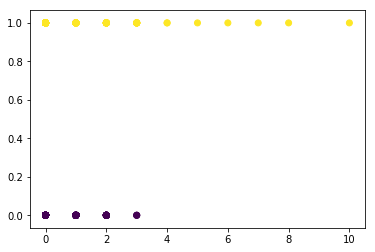

In [20]:
X_train.loc[:,'LOAN']
plt.scatter(X_train.loc[:,'DEROG'], y_train, c=y_train)


## Ejercicio 2: Elección de un modelo

Basándose en lo visto en el teórico escojan y justifiquen un modelo de aprendizaje automático. Recuerden que los pasos para elegir un modelo son:

### Selección de hipótesis

Modelo que selecciono es el de regresion logística. Clasificamos nuestros registros en dos categorías. 1 no aptos para credito y 0 aptos para crédito.

La función de predicción hw(x) debe dar una aproximación de p(y=1|x,w)
0 ≤ hw(x) ≤ 1


### Selección de regularizador

Regularización log

Nos permite que la predicción se ajuste bien a los datos, buscando que la suma de residuos de cuadrado sea pequeña (RSS). 
La seleccion del valor correcto de Lambda es primordial


### Selección de función de coste

L(w)


### Justificación de las selecciones

Se hace en los puntos anteriores

## Ejercicio 3: Selección de hiperparámetros

Utilizando búsqueda exhaustiva (*grid search*) con *5-fold cross-validation* y utilizando como métrica el área bajo la curva de ROC (o *ROC-AUC*), hagan una selección de los mejores hiperparámetros para su conjunto de datos y el modelo que hayan elegido en el apartado anterior.


In [139]:
rlog = LogisticRegression() # Creando el modelo

rlog.fit(X_train, y_train) #ajustando el modelo

# Realizando las predicciones
y_predic_train = rlog.predict(X_train) 


# Verificando la exactitud del modelo
training = (y_predic_train == y_train).sum().astype(float) / y_train.shape[0]
print("sobre datos de entrenamiento: {0:.2f}".format(training))


#Analizamos los a y b

print("")
print("intercepción ")
print(rlog.intercept_)
print("")
print("coeficientes ")
print(rlog.coef_)

sobre datos de entrenamiento: 0.84

intercepción 
[-0.]

coeficientes 
[[-2.55e-05 -2.98e-06  2.61e-07 -7.87e-03  3.51e-03  6.78e-03 -1.07e-02
   2.27e-03  2.88e-03  2.38e-02]]


In [142]:
hiperparam={
    'learning_rate': ['constant'],
    'eta0': [0.1, 0.01, 0.001],
    'alpha': [0.1, 0.01, 0.001, 0.0001]
}

clf = SGDClassifier(loss="log", penalty="l2", tol=1e-3)

model = GridSearchCV(clf, hiperparam, cv=5, scoring='roc_auc')
model.fit(X_train, y_predic_train)

print("Mejor conjunto de parámetros:")
print(model.best_params_, end="\n\n")

print("Puntajes de la grilla:", end="\n\n")
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, model.cv_results_['params']):
    print("Exactitud: %0.3f (+/-%0.03f) para los parámetros %r" % (mean, std ** 2, params))
print()

Mejor conjunto de parámetros:
{'alpha': 0.001, 'eta0': 0.001, 'learning_rate': 'constant'}

Puntajes de la grilla:

Exactitud: 0.660 (+/-0.018) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'constant'}
Exactitud: 0.663 (+/-0.018) para los parámetros {'alpha': 0.1, 'eta0': 0.01, 'learning_rate': 'constant'}
Exactitud: 0.595 (+/-0.033) para los parámetros {'alpha': 0.1, 'eta0': 0.001, 'learning_rate': 'constant'}
Exactitud: 0.669 (+/-0.020) para los parámetros {'alpha': 0.01, 'eta0': 0.1, 'learning_rate': 'constant'}
Exactitud: 0.665 (+/-0.017) para los parámetros {'alpha': 0.01, 'eta0': 0.01, 'learning_rate': 'constant'}
Exactitud: 0.665 (+/-0.018) para los parámetros {'alpha': 0.01, 'eta0': 0.001, 'learning_rate': 'constant'}
Exactitud: 0.672 (+/-0.014) para los parámetros {'alpha': 0.001, 'eta0': 0.1, 'learning_rate': 'constant'}
Exactitud: 0.672 (+/-0.022) para los parámetros {'alpha': 0.001, 'eta0': 0.01, 'learning_rate': 'constant'}
Exactitud: 0.675 (+/-0.016) pa

## Ejercicio 4: Métricas sobre el conjunto de evaluación

Una vez encontrados los mejores hiperparámetros para el modelo seleccionado en los apartados anteriores se evalúa el modelo final entrenado sobre el conjunto de datos de evaluación seleccionado en el ejercicio 1. Pueden utilizar las métricas que crean convenientes. Es mejor utilizar más de una métrica. Particularmente el *reporte de clasificación* y la *matriz de confusión* son buenos ejemplos de métricas.

In [140]:
# TODO: Evaluación del modelo

penalty = 'l1' #  Tipo de regularización: l1 (valor absoluto), l2 (cuadrados). Se selecciona l1 porque con l2 
               # el resultado no es bueno.
alpha = 0.01 
max_iter = 10 
tol = 1e-3 

model = LogisticRegression(penalty=penalty, C=1./alpha, max_iter=max_iter, tol=tol)
model.fit(X_train, y_train)

print('Exactitud para entrenamiento: %.2f' %  accuracy_score(y_train, model.predict(X_train)))
print('Exactitud para validación: %.2f' % accuracy_score(y_test, model.predict(X_test)))

Exactitud para entrenamiento: 0.87
Exactitud para validación: 0.89


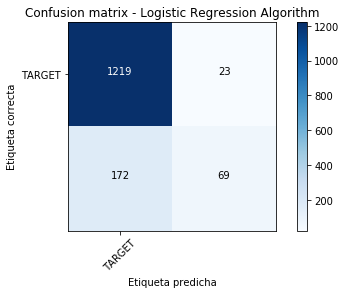

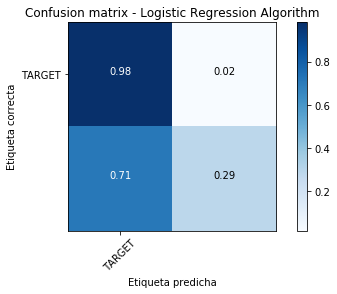

In [138]:
cnf_matrix = confusion_matrix(y_train, model.predict(X_train))
np.set_printoptions(precision=2)

# Matriz de confusión - Sin Normalizar
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["TARGET"],
                      title='Confusion matrix - Logistic Regression Algorithm')
# Matriz de confusión - Normalizada
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["TARGET"], normalize='TRUE' ,
                      title='Confusion matrix - Logistic Regression Algorithm')


plt.show()

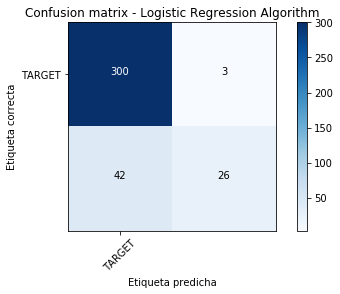

In [135]:
# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_test, model.predict(X_test))
np.set_printoptions(precision=2)

# Matriz de confusión - Sin Normalizar
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["TARGET"],
                      title='Confusion matrix - Logistic Regression Algorithm')

# Matriz de confusión - Normalizada
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["TARGET"], normalize='TRUE' ,
                      title='Confusion matrix - Logistic Regression Algorithm')


plt.show()

In [ ]:
# TODO: Redefinir umbral de clasificación a través de los resultados vistos por graficar curvas de ROC